In [40]:
#importer les packages
import pandas as pd
import numpy as np
import matplotlib.pyplot  as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import pickle
from pandas._libs.hashtable import value_count
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from ast import Lambda
import pickle

In [4]:
#lire la base de données
df=pd.read_csv("/content/sample_data/train_u6lujuX_CVtuZ9i.csv")
df

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y


In [5]:
# voir les valeurs manquantes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [6]:
df.isnull().sum().sort_values(ascending=False)

Credit_History       50
Self_Employed        32
LoanAmount           22
Dependents           15
Loan_Amount_Term     14
Gender               13
Married               3
Loan_ID               0
Education             0
ApplicantIncome       0
CoapplicantIncome     0
Property_Area         0
Loan_Status           0
dtype: int64

In [7]:
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [8]:
df.describe(include='O')

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Property_Area,Loan_Status
count,614,601,611,599,614,582,614,614
unique,614,2,2,4,2,2,3,2
top,LP001002,Male,Yes,0,Graduate,No,Semiurban,Y
freq,1,489,398,345,480,500,233,422


In [9]:
# Renseigner les valeurs manquantes
cat_data=[]
num_data=[]
for i,c in enumerate(df.dtypes):
  if c==object:
    cat_data.append(df.iloc[:,i])
  else:
    num_data.append(df.iloc[:,i])
cat_data=pd.DataFrame(cat_data).transpose()


In [10]:
num_data=pd.DataFrame(num_data).transpose()


In [11]:
# pour les variables catégoriques on va les remplacer par la valeur la plus répeter
cat_data=cat_data.apply(lambda x:x.fillna(x.value_counts().index[0]))
cat_data.isnull().sum().any()

False

In [12]:
# Pour les valeurs numériques manquantes remplacer par la valeur précédent
num_data.fillna(method='bfill',inplace=True)
num_data.isnull().sum().any()

False

In [13]:
# remplacer des valeurs
target_value={'Y':1,'N':0}
target=cat_data['Loan_Status']
cat_data.drop('Loan_Status',axis=1,inplace=True)
target=target.map(target_value)
target

0      1
1      0
2      1
3      1
4      1
      ..
609    1
610    1
611    1
612    1
613    0
Name: Loan_Status, Length: 614, dtype: int64

In [14]:
# Remplir les valeurs catégoriques par les valeurs numeriques 1,2,....
le=LabelEncoder()
for i in cat_data:
  cat_data[i]=le.fit_transform(cat_data[i])
cat_data

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Property_Area
0,0,1,0,0,0,0,2
1,1,1,1,1,0,0,0
2,2,1,1,0,0,1,2
3,3,1,1,0,1,0,2
4,4,1,0,0,0,0,2
...,...,...,...,...,...,...,...
609,609,0,0,0,0,0,0
610,610,1,1,3,0,0,0
611,611,1,1,1,0,0,2
612,612,1,1,2,0,0,2


In [15]:
cat_data.drop('Loan_ID',axis=1,inplace=True)

In [16]:
# concatiner cat_data et num_data
X=pd.concat([cat_data,num_data],axis=1)
Y=target

In [17]:
X

,Gender,Married,Dependents,Education,Self_Employed,Property_Area,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
0,1,0,0,0,0,2,5849.0,0.0,128.0,360.0,1.0
1,1,1,1,0,0,0,4583.0,1508.0,128.0,360.0,1.0
2,1,1,0,0,1,2,3000.0,0.0,66.0,360.0,1.0
3,1,1,0,1,0,2,2583.0,2358.0,120.0,360.0,1.0
4,1,0,0,0,0,2,6000.0,0.0,141.0,360.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
609,0,0,0,0,0,0,2900.0,0.0,71.0,360.0,1.0
610,1,1,3,0,0,0,4106.0,0.0,40.0,180.0,1.0
611,1,1,1,0,0,2,8072.0,240.0,253.0,360.0,1.0
612,1,1,2,0,0,2,7583.0,0.0,187.0,360.0,1.0


In [18]:
Y

0      1
1      0
2      1
3      1
4      1
      ..
609    1
610    1
611    1
612    1
613    0
Name: Loan_Status, Length: 614, dtype: int64

In [19]:
# Va commencer par la variable target
target.value_counts()


1    422
0    192
Name: Loan_Status, dtype: int64

In [20]:
#la base utilisé
df=pd.concat([cat_data,num_data,target],axis=1)

le pourcentage des cridéts accordées est :0.6872964169381107
le pourcentage des cridéts no accordées est: 0.3127035830618892


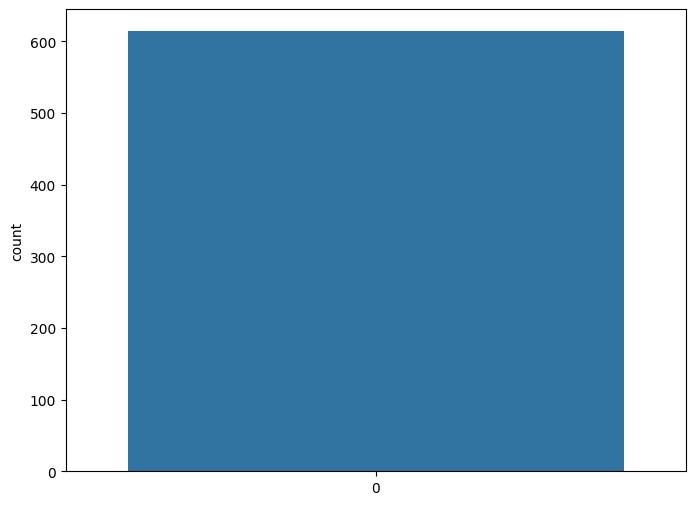

In [21]:
plt.figure(figsize=(8,6))
sns.countplot(target)
yes=target.value_counts()[1]/len(target)
no=target.value_counts()[0]/len(target)
print(f'le pourcentage des cridéts accordées est :{yes}')
print(f'le pourcentage des cridéts no accordées est: {no}')

In [22]:
print(df.columns)

Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'Property_Area', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Loan_Status'],
      dtype='object')


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:712: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


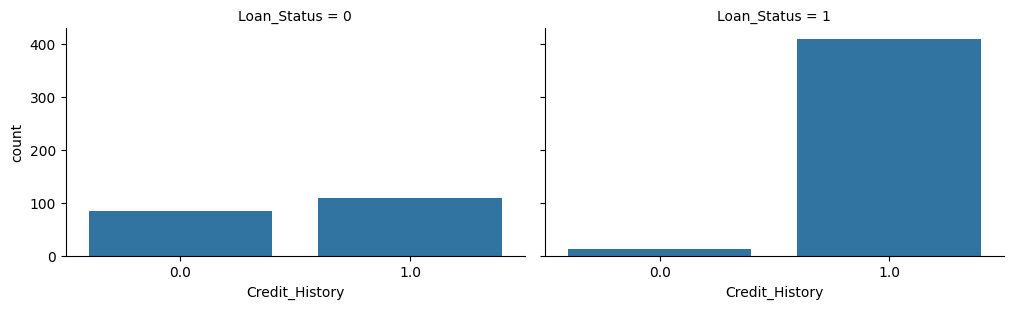

In [23]:
# credit hestory
grid= sns.FacetGrid(df,col='Loan_Status',height=3.2,aspect=1.6)
grid.map(sns.countplot,'Credit_History')

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:712: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


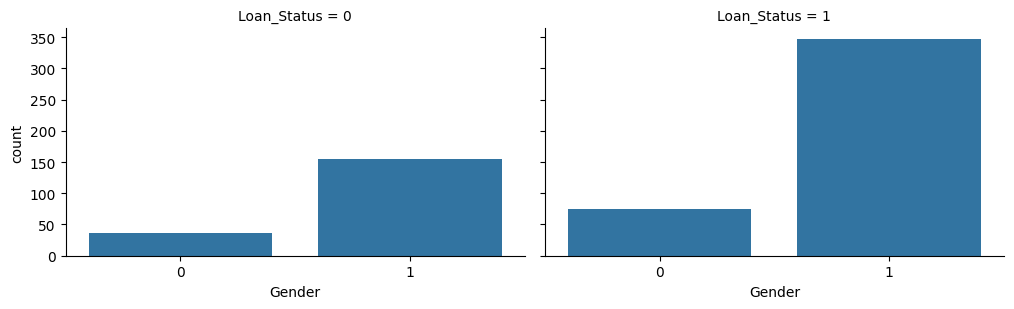

In [24]:
# Gender
grid= sns.FacetGrid(df,col='Loan_Status',height=3.2,aspect=1.6)
grid.map(sns.countplot,'Gender')

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:712: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


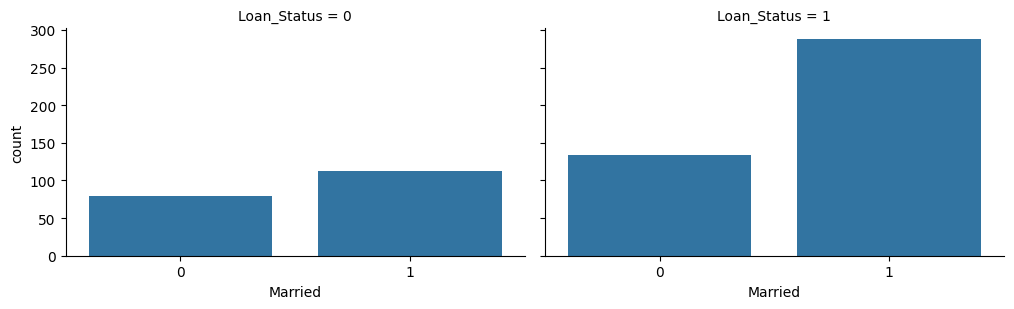

In [25]:
# Married
grid= sns.FacetGrid(df,col='Loan_Status',height=3.2,aspect=1.6)
grid.map(sns.countplot,'Married')

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:712: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


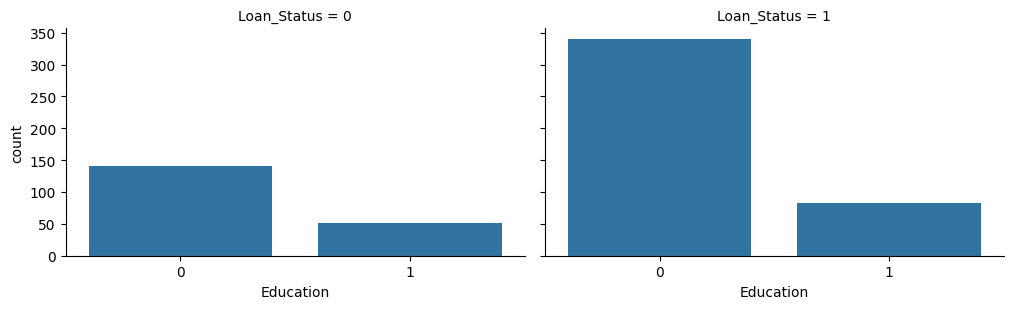

In [26]:
# Education
grid= sns.FacetGrid(df,col='Loan_Status',height=3.2,aspect=1.6)
grid.map(sns.countplot,'Education')

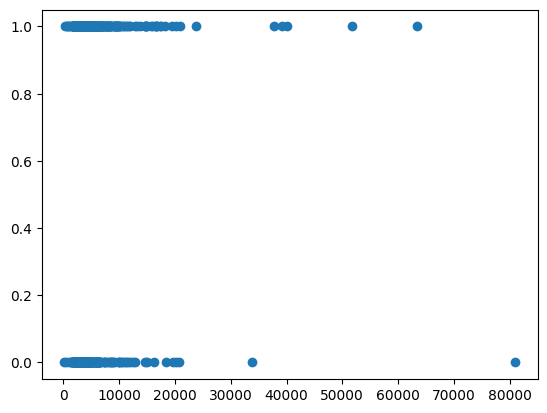

In [27]:
# affichage d'un variable numérique ,revenu du demandeur
plt.scatter(df['ApplicantIncome'],df['Loan_Status'])

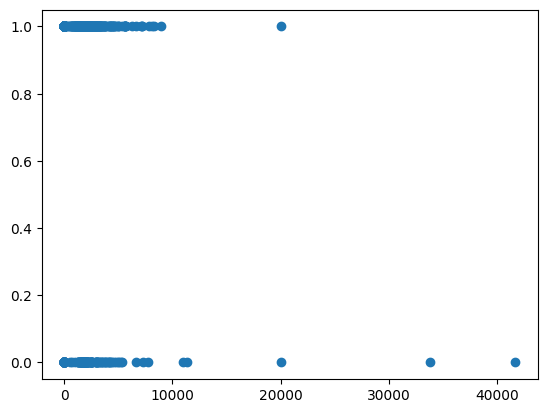

In [28]:
# revenu du demandeur
plt.scatter(df['CoapplicantIncome'],df['Loan_Status'])

In [29]:
df.groupby('Loan_Status').median()

,Gender,Married,Dependents,Education,Self_Employed,Property_Area,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
Loan_Status,,,,,,,,,,,
0,1.0,1.0,0.0,0.0,0.0,1.0,3833.5,268.0,132.5,360.0,1.0
1,1.0,1.0,0.0,0.0,0.0,1.0,3812.5,1239.5,127.5,360.0,1.0


In [30]:
# Diveser la base de données pour le test et l'entrainement
s=StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)
for train,test in s.split(X,Y):
  X_train,X_test=X.iloc[train],X.iloc[test]
  Y_train,Y_test=Y.iloc[train],Y.iloc[test]

print('X_train taille :',X_train.shape)
print('X_test taille :',X_test.shape)
print('Y_train taille :',Y_train.shape)
print('Y_test taille :',Y_test.shape)

X_train taille : (491, 11)
X_test taille : (123, 11)
Y_train taille : (491,)
Y_test taille : (123,)


In [31]:
from pandas.core.common import random_state
# An va appliquer tois algorithme Logistic regression,KNN,DecisionTree
models={
    'LogisticRegression':LogisticRegression(random_state=42),
    'KNeighborsClassifier':KNeighborsClassifier(),
    'DecisionTreeClassifier':DecisionTreeClassifier(max_depth=1,random_state=42)
}
# la fonction de précision
def accu(y_true,y_pred,retu=False):
  acc=accuracy_score(y_true,y_pred)
  if retu:
    return acc
  else:
    print(f'la precission est :{acc}')
# la fonction d'application des modeles
def train_test_eval(models,X_train,Y_train,X_test,Y_test):
  for name,model in models.items():
    print(name,":")
    model.fit(X_train,Y_train)
    accu(Y_test,model.predict(X_test))
    print('_'*30)
train_test_eval(models,X_train,Y_train,X_test,Y_test)


LogisticRegression :
la precission est :0.8536585365853658
______________________________
KNeighborsClassifier :
la precission est :0.6504065040650406
______________________________
DecisionTreeClassifier :
la precission est :0.8455284552845529
______________________________


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [32]:
X_2=X[["Credit_History","Married","CoapplicantIncome"]]

In [33]:
# Diveser la base de données pour le test et l'entrainement
s=StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)
for train,test in s.split(X_2,Y):
  X_train,X_test=X_2.iloc[train],X_2.iloc[test]
  Y_train,Y_test=Y.iloc[train],Y.iloc[test]

print('X_train taille :',X_train.shape)
print('X_test taille :',X_test.shape)
print('Y_train taille :',Y_train.shape)
print('Y_test taille :',Y_test.shape)

X_train taille : (491, 3)
X_test taille : (123, 3)
Y_train taille : (491,)
Y_test taille : (123,)


In [34]:
train_test_eval(models,X_train,Y_train,X_test,Y_test)

LogisticRegression :
la precission est :0.8536585365853658
______________________________
KNeighborsClassifier :
la precission est :0.6991869918699187
______________________________
DecisionTreeClassifier :
la precission est :0.8455284552845529
______________________________


In [37]:
# Appliquer la regressio logistique sr notre base de donnée
Classifier=LogisticRegression()
Classifier.fit(X_2,Y)

LogisticRegression()

In [41]:
# Enregistrer le modéle
pickle.dump(Classifier,open('model.pkl','wb'))